# TWO WAY DESIGN (2WD)

This lecture continues the analysis of the Wolf model of glycolytic oscillations to consider the effects of two parameters in combination.

A two way design (2WD) is used to identify interactions between factors.
This means that there is an experiment for every combination of levels of both factors.
That is, there are $n_1 \times n_2$ experiments if there are $n_i$ levels of the two factors.

## Challenges

1. **Combinatorics.**
The Wolf model has 16 parameters, which means that there are 120 interactions, each of which need to be calculated at several levels.
With 10 levels for each interaction, this results in $10 \times 10 \times 120 = 12,000$ constants to calculate.
1. **Visualization.**
How should we present the responses that clearly presents which interaction terms are displayed, their values, and patterns in the responses?
1. **Generalizing 1WD codes for 2WD**. ``runExperiments`` and other codes assumed a 1-way interaction.

# Preliminaries

## Imports

In [1]:
# First code cell in a notebook contains all installs
!apt-get install libncurses5
!pip install -q tellurium==2.2.8

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libncurses5 is already the newest version (6.3-2ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [2]:
#
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy import fftpack
import tellurium as te
import seaborn as sns

## Constants for models and simulation

In [3]:
# Constants
TIME = "time"
# Constants used in the analysis of the Wolf model
START = 0
END = 20
NUMPT = 1000  # number of points to simulate

## General helper Functions

In [4]:
TEST_MODEL = """
A -> B; k*A

k = 1
A = 0
"""
TEST_RR = te.loada(TEST_MODEL)

In [5]:
def arrToDF(arr):
    """
    Converts a NamedArray to a DataFrame.

    Parameters
    ----------
    arr: NamedArray

    Returns
    -------
    DataFrame
        Removes "[" , "]" from the names of species
        Index: time
    """
    columns = [c[1:-1] if c[0] == "[" else c for c in arr.colnames]
    df = pd.DataFrame(arr, columns=columns)
    return df.set_index(TIME)

# TESTS
rr = te.loada("A -> B; 1; A=0; B=0; a=2")
arr = rr.simulate()
df = arrToDF(arr)
assert(isinstance(df, pd.DataFrame))
trues = ["[" not in c and "]" not in c for c in df.columns]
assert(all(trues))

In [6]:
TEST_DF = arrToDF(TEST_RR.simulate())

In [7]:
def getFactorValueDct(model):
    """
    Finds the name and value of all parameters.

    Parameters
    ----------
    model: str (Antimony model)

    Returns
    -------
    dict (key: str, value: float)
    """
    rr = te.loada(model)
    dct = {}
    for parameter_name in rr.model.getGlobalParameterIds():
        try:
            rr[parameter_name] = rr[parameter_name]
            dct[parameter_name] = rr[parameter_name]
        except:
            pass
    return dct

# Tests
dct = getFactorValueDct(TEST_MODEL)
assert(isinstance(dct, dict))
assert("k" in dct.keys())
print("OK!")

OK!


## DOE Helper functions

In [8]:
def runSimulation(model, factor_dct, roadrunner=None,
      startTime=START, endTime=END, numPoint=NUMPT):
    """
    Runs a simulation for parameters with percentage changes from baseline values.

    Parameters
    ----------
    factor_dct: dict
       key: factor
       value: float
           percent change
    roadrunner: ExtendedRoadRunner
    startTime: float
    endTime: float
    numPoint: int

    Returns
    -------
    DataFrame: simulation results
        index: time
        columns: floating species
    """
    if roadrunner is None:
        roadrunner = te.loada(model)
    else:
        roadrunner.resetAll()
    for factor, percent in factor_dct.items():
        baseValue = roadrunner[factor]
        roadrunner[factor] = baseValue*(1 + 0.01*percent)
    # Run the simulation
    data = roadrunner.simulate(startTime, endTime, numPoint)
    return arrToDF(data)

# Tests
factor_dct = {"k": 10}
df = runSimulation(TEST_MODEL, factor_dct)
assert(isinstance(df, pd.DataFrame))
assert(len(df) > 0)
print("OK!")

OK!


In [9]:
def runSimulations(model, factor, percents, isPlot=True):
    """
    Runs experiments and produces plots for the percent changes in parameter values.

    Arguments
    ----------
    factor: str
    percents: list-float
        list of percent change in values
          (smallest value is -100)
    model: str (Antimony model)

    Returns
    -------
    dict:
        key: pct
        value: DataFrame
    """
    dct = {}
    for percent in percents:
        dct[percent] = runSimulation(model, {factor: percent})
    return dct

# Tests
percents = [-10, 0, 10]
resultDct = runSimulations(TEST_MODEL, "k", percents, isPlot=False)
assert(len(set(percents).symmetric_difference(resultDct.keys())) == 0)
print("OK!")

OK!


In [10]:
def calculateFft(molecule, df, offset=100):
    """
    Calculate the FFT for a molecule in the simulation output.
    The calculation does not include amplitudes at a frequency of 0.

    Arguments
    ---------
    molecule: str
    df: DataFrame
        index: time
        columns: species
    offset: int
        Initial data that are not included in the FFT calculation

    Returns
    -------
    list-float, list-float
        freqs, fftValues
    """
    times = np.array(df.index)
    values = df[molecule].values
    numPoint = len(times)
    count = numPoint - offset
    if count < 5:
        raise ValueError("Too few points. Offset is too large.")
    endTime = times[-1]
    freqs = fftpack.fftfreq(count, endTime/numPoint)
    fftValues = np.abs(fftpack.fft(values[offset:]))
    # Eliminate frequency of 0
    freqs = freqs[1:]
    fftValues = fftValues[1:]
    return freqs, fftValues

# Tests
freqs, fftValues = calculateFft("A", TEST_DF, offset=0)
assert(len(freqs) > 0)  # Top frequency should have a large magnitude
print("OK!")

OK!


In [11]:
def calculatePeak(molecule, data_df, numDelete=0, offset=100):
    """
    Calculate the FFT for a molecule in the simulation output.
    The calculation does not include amplitudes at a frequency of 0.

    Arguments
    ---------
    molecule: str
    data_df: DataFrame
    offset: int
        Initial data that are not included in the FFT calculation

    Returns
    -------
    float: peak frequency
    float: amplitude at peak frequency
    """
    def getIndexOfMax(arr):
        maxx = max(arr)
        lst = list(arr)
        return lst.index(maxx)
    def deleteArrayElement(arr, idx):
        lst = list(arr)
        lst1 = lst[:idx]
        lst2 = lst[idx+1:]
        newLst = lst1.extend(lst2)
        return np.array(lst1)
    #
    frequencies, amplitudes = calculateFft(molecule, data_df, offset=offset)
    # Delete the largest N values
    for _ in range(numDelete):
        maxIdx = getIndexOfMax(amplitudes)
        frequencies = deleteArrayElement(frequencies, maxIdx)
        amplitudes = deleteArrayElement(amplitudes, maxIdx)
    # Report the next highest value
    maxIdx = getIndexOfMax(amplitudes)
    return frequencies[maxIdx], amplitudes[maxIdx]

# TESTS
peak_frequency, peak_amplitude = calculatePeak("A", TEST_DF, offset=0)
assert(peak_frequency > 0)
print("OK!")

OK!


In [12]:
def runFFTExperiment(model, factor_dct, offset=100, **kwargs):
    """
    Runs an experiment by changing factors by the specified
    fractions and calculating FFT peak frequencies and amplitudes.

    Arguments
    ---------
    model: str (Antimony model)
    factor_dct: dict
       key: factor name
       value: percent change the parameter
    offset: int
    kwargs: dict
       keyword arguments passed to runSimulation

    Returns
    -------
    amplitude_ser: pd.Series
        index: molecule
        value: amplitude at the peak frequency
    """
    df = runSimulation(model, factor_dct, **kwargs)
    dct = {}
    for molecule in df.columns:
        _, amplitude = calculatePeak(molecule, df, offset=offset)
        dct[molecule] = amplitude
    return pd.Series(dct)

# Tests
factor_dct = {"k": 5}
ampl_ser = runFFTExperiment(TEST_MODEL, factor_dct, offset=0)
freq_ser = runFFTExperiment(TEST_MODEL, {}, offset=0)
assert(isinstance(freq_ser, pd.Series))
assert(len(freq_ser) > 0)
print("OK!")

OK!


# Wolf Model

In [13]:
WOLF_MODEL = """
// Created by libAntimony v2.12.0.3
model *Jana_WolfGlycolysis()

  // Compartments and Species:
  compartment compartment_;
  species Glucose in compartment_, fructose_1_6_bisphosphate in compartment_;
  species glyceraldehyde_3_phosphate in compartment_, glycerate_3_phosphate in compartment_;
  species pyruvate in compartment_, Acetyladehyde in compartment_, External_acetaldehyde in compartment_;
  species ATP in compartment_, ADP in compartment_, NAD in compartment_, NADH in compartment_;
  species $External_glucose in compartment_, $ethanol in compartment_, $Glycerol in compartment_;
  species $Sink in compartment_;

  // Reactions:
  J0: $External_glucose => Glucose; J0_inputFlux;
  J1: Glucose + 2 ATP => fructose_1_6_bisphosphate + 2 ADP; J1_k1*Glucose*ATP*(1/(1 + (ATP/J1_Ki)^J1_n));
  J2: fructose_1_6_bisphosphate => glyceraldehyde_3_phosphate + glyceraldehyde_3_phosphate; J2_k*fructose_1_6_bisphosphate;
  J3: glyceraldehyde_3_phosphate + NADH => NAD + $Glycerol; J3_k*glyceraldehyde_3_phosphate*NADH;
  J4: glyceraldehyde_3_phosphate + ADP + NAD => ATP + glycerate_3_phosphate + NADH; (J4_kg*J4_kp*glyceraldehyde_3_phosphate*NAD*ADP - J4_ka*J4_kk*glycerate_3_phosphate*ATP*NADH)/(J4_ka*NADH + J4_kp*ADP);
  J5: glycerate_3_phosphate + ADP => ATP + pyruvate; J5_k*glycerate_3_phosphate*ADP;
  J6: pyruvate => Acetyladehyde; J6_k*pyruvate;
  J7: Acetyladehyde + NADH => NAD + $ethanol; J7_k*Acetyladehyde*NADH;
  J8: Acetyladehyde => External_acetaldehyde; J8_k1*Acetyladehyde - J8_k2*External_acetaldehyde;
  J9: ATP => ADP; J9_k*ATP;
  J10: External_acetaldehyde => $Sink; J10_k*External_acetaldehyde;

  // Species initializations:
  Glucose = 0;
  fructose_1_6_bisphosphate = 0;
  glyceraldehyde_3_phosphate = 0;
  glycerate_3_phosphate = 0;
  pyruvate = 0;
  Acetyladehyde = 0;
  External_acetaldehyde = 0;
  ATP = 3;
  ADP = 1;
  NAD = 0.5;
  NADH = 0.5;
  External_glucose = 0;
  ethanol = 0;
  Glycerol = 0;
  Sink = 0;

  // Compartment initializations:
  compartment_ = 1;

  // Variable initializations:
  J0_inputFlux = 50;
  J1_k1 = 550;
  J1_Ki = 1;
  J1_n = 4;
  J2_k = 9.8;
  J3_k = 85.7;
  J4_kg = 323.8;
  J4_kp = 76411.1;
  J4_ka = 57823.1;
  J4_kk = 23.7;
  J5_k = 80;
  J6_k = 9.7;
  J7_k = 2000;
  J8_k1 = 375;
  J8_k2 = 375;
  J9_k = 28;
  J10_k = 80;

  // Other declarations:
  const compartment_, J0_inputFlux, J1_k1, J1_Ki, J1_n, J2_k, J3_k;
  const J4_kg, J4_kp, J4_ka, J4_kk, J5_k, J6_k, J7_k, J8_k1, J8_k2;
  const J9_k, J10_k;
end
"""

In [14]:
# Constants used in the analysis of the Wolf model
START = 0
END = 5
NUMPT = 1000  # number of points to simulate
WOLF_RR = te.loada(WOLF_MODEL)
FACTOR_DCT = getFactorValueDct(WOLF_MODEL)
WOLF_FACTORS = list(FACTOR_DCT.keys())
rr = te.loada(WOLF_MODEL)
WOLF_DF = arrToDF(rr.simulate(START, END, NUMPT))
WOLF_SPECIES = list(WOLF_DF.columns)
SPECIES = "Glucose"  # Used in tests
FACTOR = "J1_k1"  # Used in tests

# Generalize runExperiments
Generalize ``runExperiments`` so that it calculates responses for all combinations of levels of two factors.

In [15]:
def runExperiments2WD(model, factor1, factor2, percent1s, percent2s):
    """
    Runs experiments for multiple factors at different percent changes in factor levels.

    Arguments
    ---------
    model: str (Antimony model)
    factor1: str
    factor2: str
    percent1s: list-int
    percent2s: list-int

    Returns
    -------
    response2WDDataFrame;
       index: tuple of percent changes in factor values
       columns: molecule
       value: percent change from baseline
       index.name: string of tuple (rowFactor, columnFactor)
    """
    # Constants
    INDEX1 = "index1"
    INDEX2 = "index2"
    def appendSer(ser, baseSer, sers):
        adjSer = 100*(ser - baseSer) / baseSer
        sers.append(pd.DataFrame(adjSer).transpose())
    def calcResult(sers):
        resultDF = pd.concat(sers)
        resultDF[INDEX1] = index1
        resultDF[INDEX2] = index2
        resultDF = resultDF.set_index([index1, index2])
        for column in [INDEX1, INDEX2]:
            del resultDF[column]
        resultDF.index.name = str((factor1, factor2))
        return resultDF
    # Initializations
    index1 = []
    index2 = []
    amplitude_sers = []  # Collection of experiment results
    base_amplitude_ser = runFFTExperiment(model, {})
    # Calculate the changes
    for percent1 in percent1s:
        for percent2 in percent2s:
            #indices.append("%d_%d" % (percent1, percent2))
            index1.append(percent1)
            index2.append(percent2)
            factorDct = {factor1: percent1, factor2: percent2}
            amplitude_ser = runFFTExperiment(model, factorDct)
            appendSer(amplitude_ser, base_amplitude_ser, amplitude_sers)
    # Construct the result dataframe
    amplitude_df = calcResult(amplitude_sers)
    return amplitude_df

# Tests
percents = [-7, -5, -2, 0, 2, 5, 7]
response2WD_df = runExperiments2WD(WOLF_MODEL, WOLF_FACTORS[0], WOLF_FACTORS[1],
                                 percents, percents)
assert(response2WD_df.loc[(-7, -7), "Glucose"] > 0 )
print("OK!")

OK!


In [18]:
AMPLITUDE_DF = response2WD_df
AMPLITUDE_DF.index.name

"('J0_inputFlux', 'J1_k1')"

**Data: Response2WDDF**. We will describe the response for a 2WD using a dataframe structured as above.
* Columns: names of factors
* index.name: str(str, str) - factors changed
* Index: (int, int) (in same order as index)
* Values: float (percent change)

In [19]:
response2WD_df

Glucose  fructose_1_6_bisphosphate  glyceraldehyde_3_phosphate  \
-7 -7  16.980206                  18.167660                    3.301580   
   -5  30.270310                  31.617645                   14.573079   
   -2  20.550169                  21.763433                    5.236951   
    0  22.469794                  24.005382                    5.986482   
    2   9.852005                  11.270796                   -5.544185   
    5  15.594999                  17.252779                   -1.410474   
    7  12.538782                  14.199765                   -4.548449   
-5 -7  38.146138                  38.929903                   26.371271   
   -5  36.649618                  37.697193                   24.012341   
   -2  31.543922                  33.059531                   18.083325   
    0  29.986533                  31.255157                   15.870756   
    2  17.890827                  19.276356                    4.403441   
    5  22.062493                  23.505912                    7.012443   
    7  21.017896                  22.521832                    5.643017   
-2 -7  32.717714                  32.954850                   29.720521   
   -5   3.767881                   4.125378                    0.766167   
   -2  39.958310                  40.553782                   33.837205   
    0  25.960901                  26.672855                   19.223054   
    2  10.885302                  11.535822                    4.084401   
    5  35.168720                  36.133527                   25.890020   
    7  32.402969                  33.515133                   22.396851   
 0 -7  41.321259                  41.241762                   45.549260   
   -5  50.690107                  50.519695                   54.035717   
   -2   6.654408                   6.835229                    7.599896   
    0   0.000000                   0.000000                    0.000000   
    2   5.973489                   6.232485                    5.634652   
    5  40.144300                  40.698939                   37.337004   
    7  37.190805                  37.872494                   33.398673   
 2 -7  56.083608                  55.352434                   71.175682   
   -5  46.078222                  45.701187                   58.009175   
   -2  54.059171                  53.456974                   65.171764   
    0  51.942355                  51.501920                   61.637208   
    2  48.383900                  48.252990                   56.827537   
    5  26.407527                  26.484232                   31.579399   
    7  30.011637                  30.082905                   34.141552   
 5 -7  73.925922                  71.823900                  110.263190   
   -5  72.851323                  71.007706                  106.988654   
   -2  22.110229                  21.091312                   44.168520   
    0   8.659442                   7.507569                   27.235405   
    2  23.016462                  21.921301                   42.109133   
    5  40.890535                  40.198679                   61.196967   
    7  20.605162                  20.186540                   36.524973   
 7 -7  82.273854                  79.238329                  135.028468   
   -5  69.350733                  66.772657                  116.788802   
   -2  68.312770                  66.169864                  112.832122   
    0  67.550409                  65.597758                  109.556175   
    2  57.362291                  55.631693                   95.223217   
    5  53.332790                  51.442185                   87.312186   
    7  48.197096                  46.372064                   80.005846   

       glycerate_3_phosphate    pyruvate  Acetyladehyde  \
-7 -7              -4.137452   -2.901619      33.024096   
   -5               6.454741    8.309763      48.126856   
   -2              -1.760753    0.508008      36.796522   
    0              -0.

# Visualizing results of an Experiment

We will visualize the 2FD reponses using a heatmap. The horizontal and vertical axes
will be percent changes in parameter values; cells will be colored with the change in magnitude.

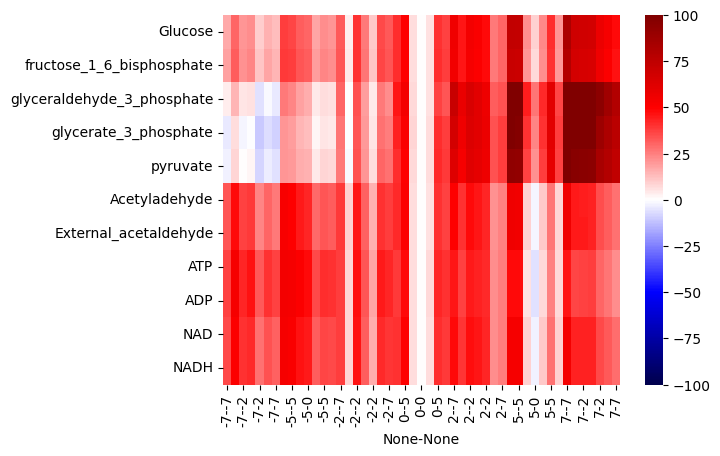

In [22]:
# Presentation of all variables that scales to a large number of interactions
percents = [-10, -5, 0, 5, 10]
response2WD_df = runExperiments2WD(WOLF_MODEL, "J1_k1", "J1_Ki", percents, percents)
_ = sns.heatmap(AMPLITUDE_DF.transpose(), cmap='seismic', vmin=-100, vmax=100)

Insights
1. All chemical species have similar trends in osciallation patterns.
1. J1_Ki has more influence on oscillation frequency than J1_k1.
1. Non-monotone effect when J1_Ki is increased in that oscillation frequency increase and then radically fall.

## Visualizing interactions for a single molecule

The following code makes use of the pandas ``pivot`` function to create a table where rows and columns represent different levels of the two factors.

In [23]:
def pivotResponse(response_df, molecule):
    """
    Creates a DataFrame in which values of the parameters are rows and columns.

    Parameters
    ----------
    response_df: Response2WDDataFrame
        columns: molecule names
        rows: tuple of percent changes in parameters
        values: response
        index.name: string of tuple (rowParameter, columnParameter)
    molecule: str

    Returns
    -------
    DataFrame
        columns: values of columnParameter
        rows: values of rowParameter
        cells: response for molecule
    """
    LEVEL0 = "level_0"
    LEVEL1 = "level_1"
    df = response_df.reset_index()
    result_df = pd.pivot_table(df, values=molecule, index=LEVEL0, columns=LEVEL1)
    parameters = eval(response_df.index.name)
    result_df.index.name = parameters[0]
    result_df.columns.name = parameters[1]
    return result_df

# Tests
df = pivotResponse(AMPLITUDE_DF, "Glucose")
assert(len(df.index) == len(df.columns))
print("OK!")

OK!


In [24]:
df

J1_k1,-7,-5,-2,0,2,5,7
J0_inputFlux,,,,,,,
-7,16.980206,30.270310,20.550169,22.469794,9.852005,15.594999,12.538782
-5,38.146138,36.649618,31.543922,29.986533,17.890827,22.062493,21.017896
-2,32.717714,3.767881,39.958310,25.960901,10.885302,35.168720,32.402969
0,41.321259,50.690107,6.654408,0.000000,5.973489,40.144300,37.190805
2,56.083608,46.078222,54.059171,51.942355,48.383900,26.407527,30.011637
5,73.925922,72.851323,22.110229,8.659442,23.016462,40.890535,20.605162
7,82.273854,69.350733,68.312770,67.550409,57.362291,53.332790,48.197096


A function that encapsulates the foregoing for the output of 2WD experiments.

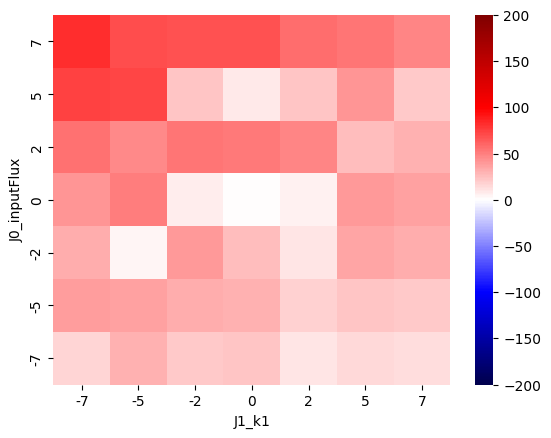

In [25]:
def makeHeatmap(responseDF, molecule, isColorbar=True, ax=None, vmin=-100, vmax=100, cbar_ax=None):
    """
    Creates a heatmap showing the interactions of response values for two parameters.

    Parameters
    ----------
    reponseDF: DataFrame
        index: tuples of percent changes in parameter values
        columns: molecule
        values: response
    molecule: str
    isColorbar: bool
        show the colorbar
    vmin: float
        minimum value in color bar
    vmax: float
        maximum value in color bar
    cbar_ax: Axes
    """
    df = pivotResponse(responseDF, molecule)
    df = df.sort_index(ascending=False)  # Show large values on top
    if ax is None:
        ax = sns.heatmap(df, cmap='seismic', vmin=vmin, vmax=vmax, cbar=isColorbar, cbar_ax=cbar_ax)
    else:
        _ = sns.heatmap(df, cmap='seismic', vmin=vmin, vmax=vmax, cbar=isColorbar, ax=ax, cbar_ax=cbar_ax)
    return ax

# Tests
_ = makeHeatmap(AMPLITUDE_DF, "Glucose", vmin=-200, vmax=200)

# Calculating DOE Parameters

For 2WD, we must calculate $\mu, \alpha_{i, k_i}, \alpha_{i, k_i, j, k_j}$.
1. Use 1WD to obtain $\mu, \alpha_{i, k_i}$
1. Calculate $y_{i, k_i, j, k_j}$ responses
1. Calculate $\alpha_{i, k_i, j, k_j}$: $\alpha_{i, k_i, j, k_j} = y_{i, k_i, j, k_j} - \mu
- \alpha_{i, k_i} - \alpha_{j, k_j}$

## Calculating $\alpha_{i, k_i}$

A 2WD experiment contains information from two 1WD experiments.
The function ``calc1WDParameters`` calculates $\mu$, $\alpha_{i, k_i}$, $\alpha_{j, k_j}$.

In [32]:
def calc1WDParameters(response2WDDF):
    """
    Constructs a 1WD response for a single molecule from the results for a 2WD experiment.

    Parameters
    ----------
    response2WDDF: DataFrame (Response2WDDF)
    factor: str
    molecule: str

    Returns
    -------
    Series: mu
    DataFrame
        index: int (percent change)
        value: float (alpha_i,k_i)
    DataFrame:
        index: int (percent change)
        value: float (alpha_j,k_j)
    """
    def calcFactorSer(pos):
        """
        Calculates the Series for a factor.

        Parameters
        ----------
        pos: int
            in the set {0, 1}

        Returns
        -------
        DataFrame
        """
        # Find the levels
        levels = list(set([i[pos] for i in response2WDDF.index]))
        levels.sort()
        # Find the indices that determine the 1WD responses
        indices = [(i, 0) for i in levels]
        if pos == 1:
            indices = [(j, i) for i,j in indices]
        #
        df = response2WDDF.loc[indices]
        newIndices = [i[pos] for i in df.index]
        df.index = newIndices
        return df
    #
    mu = response2WDDF.loc[(0, 0), :]
    alphaiDF = calcFactorSer(0) - mu
    alphajDF = calcFactorSer(1) - mu
    #
    return mu, alphaiDF, alphajDF

# TESTS
muSer, df1, df2 = calc1WDParameters(AMPLITUDE_DF)
assert(all([m == 0 for m in muSer]))
for df in [df1, df2]:
    assert(isinstance(df, pd.DataFrame))
print("OK!")

OK!


In [33]:
df2

,Glucose,fructose_1_6_bisphosphate,glyceraldehyde_3_phosphate,glycerate_3_phosphate,pyruvate,Acetyladehyde,External_acetaldehyde,ATP,ADP,NAD,NADH
-7,41.321259,41.241762,45.549260,43.350876,41.184643,41.815650,41.850319,39.044737,39.044737,40.421402,40.421402
-5,50.690107,50.519695,54.035717,52.175710,50.691171,51.211626,51.252571,48.368252,48.368252,50.029026,50.029026
-2,6.654408,6.835229,7.599896,7.952445,7.133270,6.887619,6.937037,6.937347,6.937347,6.626421,6.626421
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,5.973489,6.232485,5.634652,6.551142,6.588797,6.140830,6.143095,7.253501,7.253501,6.466535,6.466535
5,40.144300,40.698939,37.337004,40.853684,41.710649,40.377419,40.389036,42.605718,42.605718,41.214323,41.214323
7,37.190805,37.872494,33.398673,37.692384,39.055903,37.300727,37.307339,40.351688,40.351688,38.509205,38.509205


## Calculating $\beta_{i, k_i, j, k_j}$

In [34]:
# Constants
MU = "mu"
ALPHA_I = "alpha_i"
ALPHA_J = "alpha_j"
BETA_IJ = "beta_ij"

In [35]:
def calc2WDParameters(response2WDDF):
    """
    Calculates the design of experiment parameters for a 2-Way Design.
    Assumes that there is a level of 0.

    Parameters
    ----------
    DataFrame
       index: tuple of percent changes in factor values
       columns: molecule
       value: float (response)
       index.name: string of tuple (rowFactor, columnFactor)

    Returns
    -------
    dct: dict
        "mu": Series: mu values for factors
        "alpha_i": pd.DataFrame: alpha_i,k_i
             column: molecule
             index: factor i levels
             value: float
        "alpha_j": pd.DataFrame: alpha_j,k_j
             column: molecule
             index: factor j levels
             value: float
        "beta_ij" pd.DataFrame: beta_i,k_i,j,k_j
            column: molecule
             index: factor i, factor j levels
             value: float
    """
    mu_ser, alpha_i_df, alpha_j_df = calc1WDParameters(response2WDDF)
    beta_ij_df = response2WDDF - mu_ser
    # Adjust for alpha_i_ki and alpha_j_kj
    for idx, row in beta_ij_df.iterrows():
        iLevel, jLevel = idx
        beta_ij_df.loc[idx, :] = beta_ij_df.loc[idx, :].values - alpha_i_df.loc[iLevel, :].values  \
            - alpha_j_df.loc[jLevel, :].values
    #
    return {MU: mu_ser,
            ALPHA_I: alpha_i_df,
            ALPHA_J: alpha_j_df,
            BETA_IJ: beta_ij_df,
           }

# TESTS
result_dct = calc2WDParameters(AMPLITUDE_DF)
assert(isinstance(result_dct[MU], pd.Series))
assert(isinstance(result_dct[ALPHA_I], pd.DataFrame))
assert(isinstance(result_dct[ALPHA_J], pd.DataFrame))
assert(isinstance(result_dct[BETA_IJ], pd.DataFrame))
assert(len(result_dct[BETA_IJ]) == len(result_dct[ALPHA_I])*len(result_dct[ALPHA_J]))
print("OK!")

OK!


In [36]:
result_dct[BETA_IJ]

Glucose  fructose_1_6_bisphosphate  glyceraldehyde_3_phosphate  \
-7 -7 -46.810848                 -47.079484                  -48.234163   
   -5 -42.889592                 -42.907432                  -45.449121   
   -2  -8.574034                  -9.077178                   -8.349428   
    0   0.000000                   0.000000                    0.000000   
    2 -18.591278                 -18.967071                  -17.165320   
    5 -47.019095                 -47.451542                  -44.733960   
    7 -47.121817                 -47.678111                  -43.933605   
-5 -7 -33.161654                 -33.567016                  -35.048746   
   -5 -44.027022                 -44.077659                  -45.894132   
   -2  -5.097018                  -5.030855                   -5.387327   
    0   0.000000                   0.000000                    0.000000   
    2 -18.069194                 -18.211286                  -17.101967   
    5 -48.068339                 -48.448184                  -46.195317   
    7 -46.159441                 -46.605819                  -43.626412   
-2 -7 -34.564446                 -34.959767                  -35.051794   
   -5 -72.883127                 -73.067172                  -72.492605   
   -2   7.343001                   7.045698                    7.014254   
    0   0.000000                   0.000000                    0.000000   
    2 -21.049088                 -21.369518                  -20.773306   
    5 -30.936481                 -31.238267                  -30.670038   
    7 -30.748737                 -31.030216                  -30.224877   
 0 -7   0.000000                   0.000000                    0.000000   
   -5   0.000000                   0.000000                    0.000000   
   -2   0.000000                   0.000000                    0.000000   
    0   0.000000                   0.000000                    0.000000   
    2   0.000000                   0.000000                    0.000000   
    5   0.000000                   0.000000                    0.000000   
    7   0.000000                   0.000000                    0.000000   
 2 -7 -37.180007                 -37.391248                  -36.010786   
   -5 -56.554240                 -56.320429                  -57.663750   
   -2  -4.537592                  -4.880175                   -4.065340   
    0   0.000000                   0.000000                    0.000000   
    2  -9.531944                  -9.481416                  -10.444323   
    5 -65.679127                 -65.716627                  -67.394812   
    7 -59.121522                 -59.291509                  -60.894329   
 5 -7  23.945221                  23.074569                   37.478524   
   -5  13.501774                  12.980442                   25.717531   
   -2   6.796379                   6.748515                    9.333219   
    0   0.000000                   0.000000                    0.000000   
    2   8.383531                   8.181247                    9.239076   
    5  -7.913206                  -8.007829                   -3.375442   
    7 -25.245085                 -25.193523                  -24.109106   
 7 -7 -26.597815                 -27.601191                  -20.076967   
   -5 -48.889784                 -49.344796                  -46.803091   
   -2  -5.892047                  -6.263123                   -4.323949   
    0   0.000000                   0.000000                    0.000000   
    2 -16.161607                 -16.198551                  -19.967610   
    5 -54.361919                 -54.854512                  -59.580993   
    7 -56.544119                 -57.098188                  -62.949003   

       glycerate_3_phosphate   pyruvate  Acetyladehyde  External_acetaldehyde  \
-7 -7             -47.088064 -46.182961     -47.254821             -47.287162   
   -5             -45.320705 -44.478107     -41.548036             -41.559375   
   -2          

# Running a Study

A study for 2WD must considerations *combinations* of changes in levels for two factors.
So, running a study must specify: (a) the list of factors considered for changes in combinations
and (b) the levels of factors.

## Calculating responses for 2WD

In [37]:
def runStudy2WD(model, factor1, factor2, percents):
    """
    Calculates parameters for a 2WD study.

    Parameters
    ----------
    molecule: str
    factor1: str
    factor2: str
    percents: list-int

    Returns
    -------
    Series: mean values
    pd.DataFrame: alpha_i,k_i (response2WDDF)
    pd.DataFrame: alpha_j,k_j (response2WDDF)
    pd.DataFrame: alpha_i,k_i,j,k_j (response2WDDF)
    """
    # Get the 2WD parameters
    frequency_df = runExperiments2WD(model, factor1, factor2, percents, percents)
    #
    return calc2WDParameters(frequency_df)

# TESTS
result_dct = runStudy2WD(WOLF_MODEL, "J1_Ki", "J1_k1", [-10, -7, -5, 0, 5, 7, 10])
assert(isinstance(result_dct[MU], pd.Series))
for df in [d for k, d in result_dct.items() if k != MU]:
    assert(len(df) > 0)
    assert(isinstance(df, pd.DataFrame))
print("OK!")

OK!


In [38]:
result_dct[ALPHA_I]

,Glucose,fructose_1_6_bisphosphate,glyceraldehyde_3_phosphate,glycerate_3_phosphate,pyruvate,Acetyladehyde,External_acetaldehyde,ATP,ADP,NAD,NADH
-10,85.386606,80.892023,124.323882,94.351397,75.748635,88.307937,88.528524,61.303705,61.303705,73.561932,73.561932
-7,96.892301,93.714152,123.958001,103.105513,90.396992,98.554684,98.743599,78.789813,78.789813,88.458466,88.458466
-5,79.798017,78.120536,96.981968,84.017728,76.273856,80.861936,81.006038,69.245460,69.245460,74.666376,74.666376
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,-4.854481,-3.772322,-11.968448,-4.738460,-2.117119,-4.600112,-4.653336,0.428271,0.428271,-2.232223,-2.232223
7,-28.500089,-27.541056,-35.516348,-28.147823,-25.379645,-28.294895,-28.343074,-24.044198,-24.044198,-25.810693,-25.810693
10,-99.608468,-99.842400,-99.781674,-99.612010,-98.952177,-98.902914,-98.893441,-99.741890,-99.741890,-99.513768,-99.513768


OK!


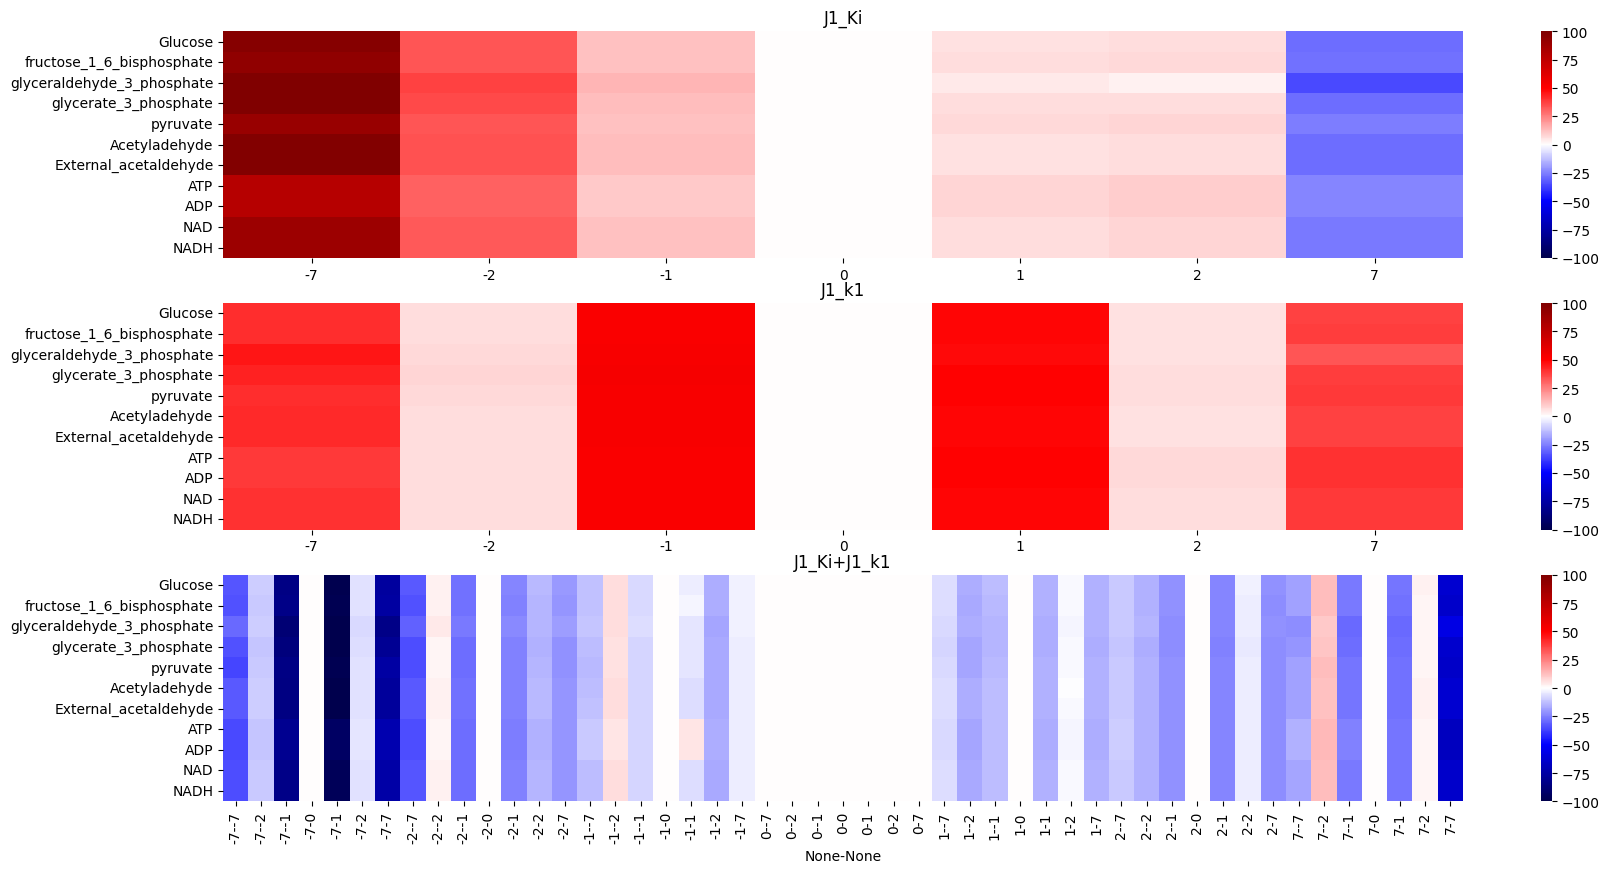

In [39]:
def plot2WD(model, factor1, factor2, percents, figsize=(20, 10), vmin=-100, vmax=100, is_plot=True):
    """
    Plots the alpha for 1WD and 2WD.

    Parameters
    ----------
    molecule: str
    factor1: str
    factor2: str
    percents: list-int
    figisze: tuple-int
       Size of figures
    """
    def plotParameters(df, ax, factor):
        sns.heatmap(df.T, cmap='seismic', vmin=vmin, vmax=vmax, ax=ax)
        ax.set_title(factor)
    #
    # Get the 2WD parameters
    dct = runStudy2WD(model, factor1, factor2, percents)
    fig, axes = plt.subplots(3, figsize=figsize)
    plotParameters(dct[ALPHA_I], axes[0], factor1)
    plotParameters(dct[ALPHA_J], axes[1], factor2)
    plotParameters(dct[BETA_IJ], axes[2], factor1 + "+" + factor2)
    if not is_plot:
        plt.close()


# TESTS
plot2WD(WOLF_MODEL, "J1_Ki", "J1_k1", [-7, -2, -1, 0, 1, 2, 7], is_plot=True)
print("OK!")

## Question
1. Analyze realtive frequencies for Glucose.

## Solution

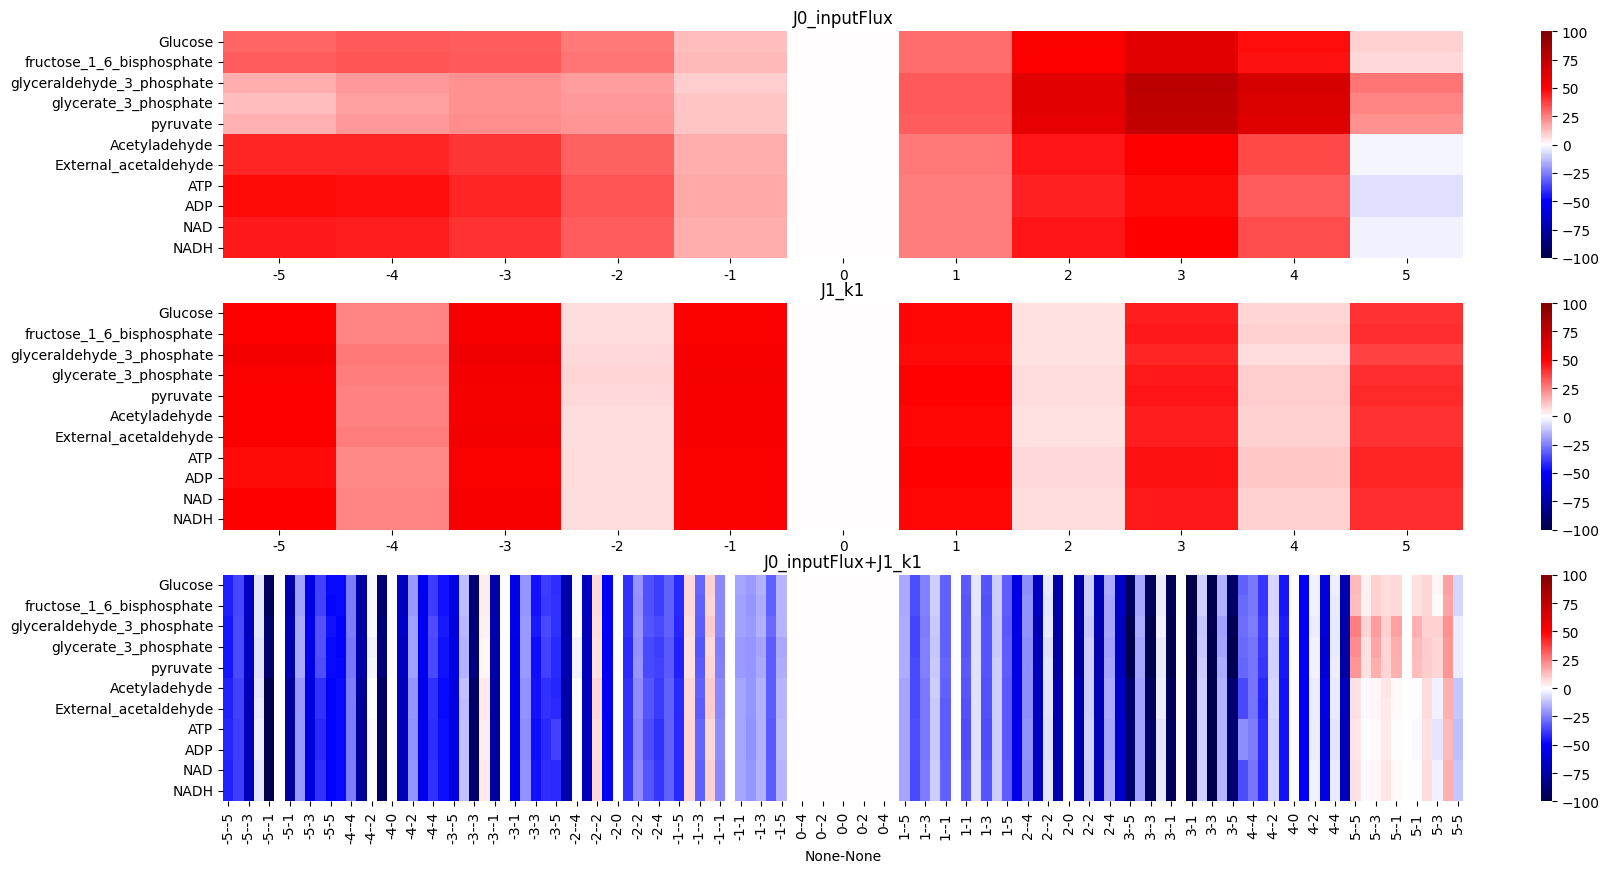

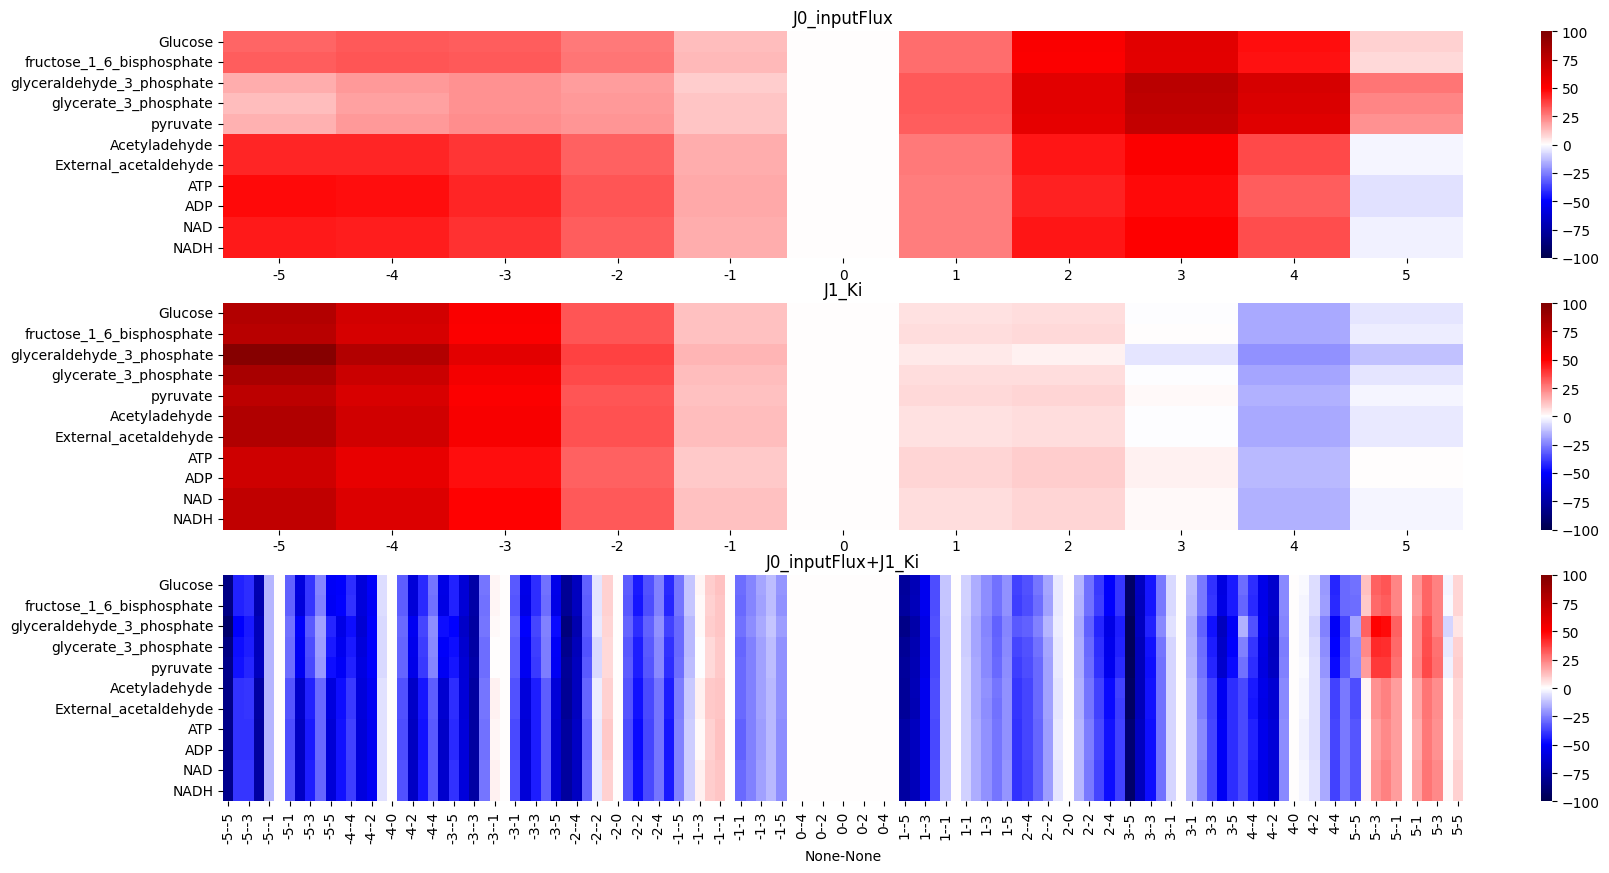

In [40]:
# Analysis for frequency with relative (precentage) responses
percents = 3*(np.array(range(7)) - 3)
percents = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
for prm in WOLF_FACTORS[1:3]:
    plot2WD(WOLF_MODEL, WOLF_FACTORS[0], prm, percents)

## Question
1. Which combination of parameters for which response suggest a strong interaction between parameter pairs?# Analysis for frequency with relative (precentage) responses